In [14]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
import warnings
warnings.filterwarnings('ignore')

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

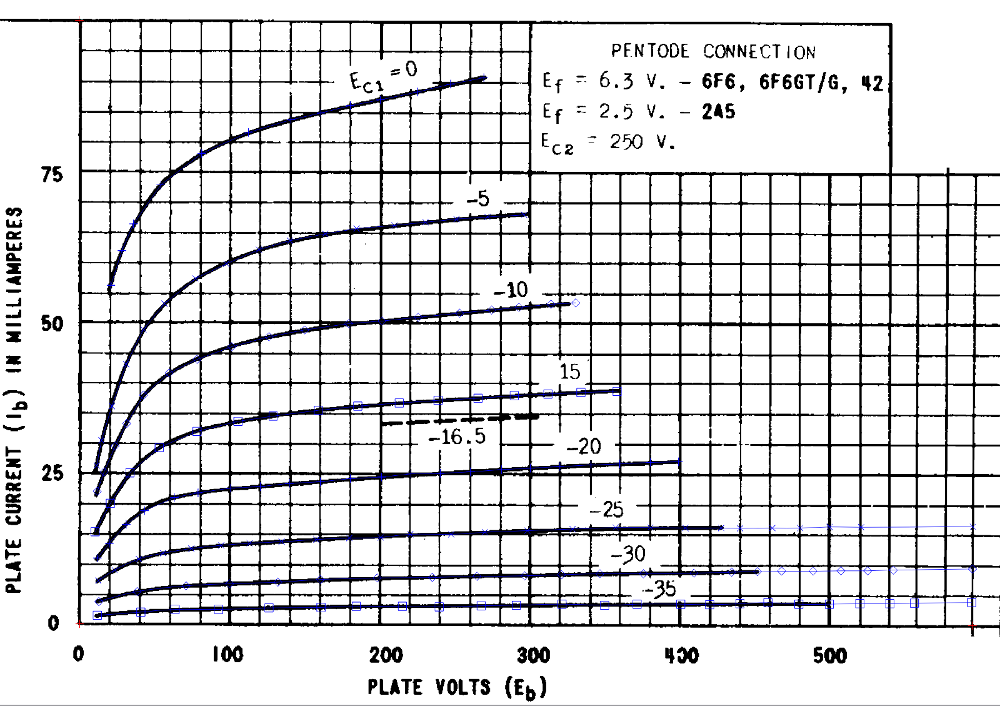

In [15]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import sys
from scipy import interpolate
import math
from ipywidgets import *
from scipy.fftpack import fft
from scipy.optimize import fsolve

# used engauge to extract plot data from datasheet
fn = "6f6g.csv"
datasheetCurveData = pd.read_csv(fn)
from IPython.display import Image
Image("6f6g.engauge.png")

In [16]:
colnames = datasheetCurveData.columns.values
colcount = len(colnames)
rowcount = len(datasheetCurveData[colnames[0]])

# do a little clean up
# remove negative values of plate current
for i in range(1,colcount):
    for j in range(rowcount):
        if datasheetCurveData[colnames[i]][j] < 0.00:
            datasheetCurveData[colnames[i]][j] = 0.0

a = """  
# this is no longer true, engauge interpolates plots to the required end point
# engauge adds bogus points on curves where plate voltage is greater than curve
# scan through array data column at a time, find point where engauge starts duplicating data
# calculate slope and y-axis intercept (m, b) then fill data past that point with a line

for i in range(1,colcount):
    m = 0
    b = 0
    for j in range(rowcount):
        if datasheetCurveData[colnames[i]][j] > 0.01:
            try:
                if m == 0:
                    if datasheetCurveData[colnames[i]][j] == datasheetCurveData[colnames[i]][j+40]:
                        # now need to find the average of the past slopes
                        slopeCount = 10
                        sum = 0
                        for k in range(j-slopeCount,j):
                            sum += (datasheetCurveData[colnames[i]][k] - datasheetCurveData[colnames[i]][k-1])/(datasheetCurveData['PlateVoltage'][k] - datasheetCurveData['PlateVoltage'][k-1])
                        m = sum / slopeCount;
                        if m < 0.0:
                            m = 0.0;
                        b = datasheetCurveData[colnames[i]][j] - m*datasheetCurveData['PlateVoltage'][j]
                        # print j,datasheetCurveData[colnames[i]][j],m,b
                if m != 0:
                    datasheetCurveData[colnames[i]][j] = m*datasheetCurveData['PlateVoltage'][j] + b
            except KeyError:
                pass # j+2 is now > rowcount for the higher curves
"""

In [17]:
datasheetCurveData.head(5)

,PlateVoltage,0,-5,-10,-15,-20,-25,-30,-35
0,10.474,0.047873,0.024839,0.020985,0.015277,0.010501,0.006812,0.003508,0.001409
1,11.548,0.048705,0.026250,0.021739,0.015771,0.010824,0.006999,0.003590,0.001427
2,11.867,0.048952,0.026669,0.021963,0.015917,0.010920,0.007055,0.003615,0.001432
3,11.880,0.048962,0.026686,0.021972,0.015923,0.010924,0.007057,0.003616,0.001432
4,11.895,0.048974,0.026706,0.021983,0.015930,0.010928,0.007060,0.003617,0.001433


In [18]:
datasheetCurveData.tail(5)

,PlateVoltage,0,-5,-10,-15,-20,-25,-30,-35
153,546.988,0.103723,0.071564,0.056300,0.040136,0.027800,0.016310,0.009195,0.003637
154,561.172,0.104397,0.071771,0.056494,0.040245,0.027872,0.016335,0.009260,0.003724
155,599.652,0.106225,0.072334,0.057022,0.040541,0.028068,0.016413,0.009396,0.003847
156,600.188,0.106251,0.072342,0.057030,0.040545,0.028071,0.016414,0.009397,0.003848
157,600.461,0.106263,0.072346,0.057033,0.040547,0.028072,0.016415,0.009398,0.003849


In [19]:
#initial values
Ia = 0.034  #plate current mA
ScreenRatio = 5.33 #average ratio of plate/screen current  
Va = 126.6   #plate voltage V
Rl = 4       #speaker impedance
n  = 33      #pri/sec turns ratio
Pd = 11      #plate dissipation max

VaMAX = 600.01
IaMAX = 0.1001
GraphWidth = 840 # get these from jpg size 
GraphHeight = 560

# later, we find intersection of loadline with plate current curves by resampling
# so all have the same x values.
# http://stackoverflow.com/questions/17928452/find-all-intersections-of-xy-data-point-graph-with-numpy
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html

PlateVoltages = np.arange(0,VaMAX,1.0)

saturationCurveVoltage = '0V'
cutoffCurveVoltage = '-35'

# creating 1D interpolation functions from the datasheet extracted curves
iaf = {}
for i in range(1,colcount):
    iaf[colnames[i]] = {'valueAt': None,'loadLineIntersectionV':0,'loadLineIntersectionI':0}
    iaf[colnames[i]]['valueAt'] = interpolate.interp1d(datasheetCurveData['PlateVoltage'].tolist(), datasheetCurveData[colnames[i]].tolist())

def plot(_Ia,_Va,_Rl,_n):
    global i0intersect, i16intersect,Ia,Va,Rl,n,b,m,Pd,ScreenRatio
    global gridvoltages,platevoltages
    global colcount, datasheetCurveData
    Ia = _Ia # set the slider values to global
    Is = _Ia / ScreenRatio
    Va = _Va
    Rl = _Rl
    n  = _n

    # plot the csv colums versus plate/anode voltage
    fig = plt.figure(figsize=(15, 10))
    null = [plt.plot(datasheetCurveData['PlateVoltage'],
                     datasheetCurveData[colnames[x]],label='') for x in range(1,colcount)]
    plt.grid(linestyle='--', linewidth=0.5)
    null = plt.xticks(np.arange(0,VaMAX,20))
    null = plt.yticks(np.arange(0,IaMAX,0.01))

    # plot power dissipation limit curve
    null = plt.plot(PlateVoltages, Pd/PlateVoltages,label='Power Limit',linestyle='--')

    null = plt.xlim([0,VaMAX])
    null = plt.ylim([0,IaMAX])

    def placeLabel(plt,text,x,y,angle):
        null = plt.annotate(s=text,
                        rotation=angle,
                        xy=(x,y),
                        xycoords='data',
                        xytext=(0,0),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        # arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=70,rad=10")
                           )


    powerLimitVoltage = 120.0
    slope = -Pd/(powerLimitVoltage*powerLimitVoltage)
    graphSlope = slope*(GraphHeight/IaMAX)/(GraphWidth/VaMAX)
    angle = (180.0/np.pi) * np.arctan(graphSlope)
    placeLabel(plt,"Power\n%.1fW"%Pd,powerLimitVoltage,Pd/powerLimitVoltage,angle)

    for i in range(1,colcount):
        l = colnames[i]
        for j in range(rowcount):
            x = datasheetCurveData['PlateVoltage'][j]
            if datasheetCurveData['PlateVoltage'][j]*datasheetCurveData[colnames[i]][j] > (Pd+1.0):
                placeLabel(plt,l,x,datasheetCurveData[colnames[i]][j],0)
                break
            else:
                if j == rowcount - 1:
                    placeLabel(plt,l,x - 15,datasheetCurveData[colnames[i]][j],0)
                    break
                    
    plateImpedance = float(Rl * n**2)

    m = -1/plateImpedance
    b = Ia + Va/plateImpedance
    ll = m*PlateVoltages+b

    null = plt.plot(PlateVoltages,ll,label='%d ohm Load'%Rl)
    null = plt.plot(Va,Ia, 'or',label='Op Point',color='g')

    gridvoltages  = []
    platevoltages = []
    for i in range(1,colcount):
        mindiff = 10
        for v in PlateVoltages:
            try:
                ia = iaf[colnames[i]]['valueAt'](v)
                iall = m*v+b
                diff = abs(ia - iall)

                if diff < mindiff:
                    vinter = v
                    iinter = iall
                    mindiff = diff
            except ValueError:
                pass
        gridvoltages.append(float(colnames[i]))
        platevoltages.append(vinter)
        iaf[colnames[i]]['loadLineIntersectionV'] = vinter
        iaf[colnames[i]]['loadLineIntersectionI'] = iinter

        if colnames[i] == cutoffCurveVoltage:
            break

    vsat = iaf[colnames[1]]['loadLineIntersectionV']
    isat = iaf[colnames[1]]['loadLineIntersectionI']
    null = plt.annotate(s="%.1fV@%.1fmA"%(vsat,isat*1000),
                        xy=(vsat,isat),
                        xycoords='data',
                        xytext=(-30,120),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=110,rad=10"))
    null = plt.annotate(s="%.1fV@%.1fmA"%(Va,Ia*1000),
                        xy=(Va,Ia),
                        xycoords='data',
                        xytext=(-120,-30),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=70,rad=10"))
    vcut = iaf[cutoffCurveVoltage]['loadLineIntersectionV']
    icut = iaf[cutoffCurveVoltage]['loadLineIntersectionI']
    null = plt.annotate(s="%.1fV@%.1fmA"%(vcut,icut*1000),
                        xy=(vcut,icut),
                        xycoords='data',
                        xytext=(-120,-10),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="angle,angleA=0,angleB=50,rad=10"))
    
    
    # from RCA RC-22 P19
    distortion = abs((((icut+isat)/2 - Ia)/(icut-isat))*100)
    
      
    # figuring out the bias voltage and cathode resistor
    row = np.where(datasheetCurveData['PlateVoltage'] > Va)[0][0]
    # print row, datasheetCurveData['PlateVoltage'][row],datasheetCurveData['PlateVoltage'][row-1]

    for col in range(1,colcount):
        x = datasheetCurveData[colnames[col]][row]
        if x < Ia:
            x1 = x
            y1 = float(colnames[col])
            x2 = datasheetCurveData[colnames[col-1]][row]
            y2 = float(colnames[col-1])
            # print x1,y1,x2,y2
            m = (y2 - y1)/(x2 - x1)
            b = y1 - m*x1
            Vc = m*Ia + b
            break
    Rc = abs(Vc/(Ia+Is))
    
    dvlower = Va - vsat
    dilower = isat - Ia
    dvhigher = vcut - Va
    dihigher = Ia - icut

    if dvlower < dvhigher:
        # closer to saturation
        Pout =  dvlower*(1/math.sqrt(2))*dilower
        title = "~%.2fW@%.1f%% - closer to saturation\n%dohms => %dohms\nVc=%0.1fV, Ia=%.1fmA, Is=%.1fmA Rc=%dohms"%(
                                                                            Pout,
                                                                            distortion,
                                                                            Rl,
                                                                            plateImpedance,
                                                                            Vc,Ia*1000,Is*1000,Rc)
        null = plt.plot((vsat,Va),(isat,Ia),linewidth=2,color='b')
    else:
        # closer to cutoff
        Pout =  (vcut-Va)*(1/math.sqrt(2))*(Ia-icut)
        title = "~%.2fW@%.1f%% - closer to cutoff\n%dohms => %dohms\nVc=%0.1fV, Ia=%.1fmA, Is=%.1fmA, Rc=%dohms"%(
                                                                        Pout,
                                                                        distortion,
                                                                        Rl,
                                                                        plateImpedance,
                                                                        Vc,Ia*1000,Is*1000,Rc)
        null = plt.plot((Va,vcut),(Ia,icut),linewidth=2,color='b')



    for i in range(1,colcount):
        if iaf[colnames[i]]['loadLineIntersectionV']:
            vinter = iaf[colnames[i]]['loadLineIntersectionV']
            iinter = iaf[colnames[i]]['loadLineIntersectionI']
            null = plt.plot(vinter,iinter,'or',color='#EEEEEE')


    null = plt.suptitle(title,fontsize=14, fontweight='bold')
    null = plt.legend()
    
# https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
null = interact(plot,
             _Ia=widgets.FloatSlider(min=0.001,max=0.050,step=0.001,value=Ia,continuous_update=False,readout_format='.3f'),
             _Va=widgets.FloatSlider(min=50,max=400,step=5,value=300,continuous_update=False,readout_format='d'),
             _Rl=widgets.FloatSlider(min=2,max=16,step=1,value=4,continuous_update=False,readout_format='.1f'),
             _n =widgets.FloatSlider(min=10,max=50,step=1,value=46,continuous_update=False,readout_format='.1f'))


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMDM0LCBjb250aW51b3VzX3VwZGF0ZT1GYWxzZSwgZGVzY3JpcHRpb249dSdfSWEnLCBtYXg9MC4wNSwgbWluPTAuMDDigKY=


In [20]:
def plot(_biasvoltage,_amplitude):
    global coeff,platevfit,amplitude,gridvoltages,platevoltages

    coeff = np.polyfit(gridvoltages,platevoltages,4)
    platevfit = np.poly1d(coeff)
    
    biasvoltage = _biasvoltage
    amplitude = _amplitude

    # Number of samplepoints
    N = 10000
    # sample spacing
    T = 1.0 / 500.0

    t = np.linspace(0.0, N*T, N)
    gridv = (amplitude/2)*np.sin(2.0*np.pi*t)+biasvoltage
    platev = platevfit(gridv)
    
    yf = scipy.fftpack.fft(platev)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

    f = plt.figure(figsize=(20,15))
    gainplot = f.add_subplot(311)
    x = np.linspace(0,-35)
    y = platevfit(x)
    iupper = np.where(x<(biasvoltage-(amplitude/2)))[0][0]
    ilower = np.where(x<(biasvoltage+(amplitude/2)))[0][0]
    null = gainplot.plot(x[:ilower],y[:ilower],color='tab:blue')
    null = gainplot.plot(x[ilower-1:iupper],y[ilower-1:iupper],color='tab:green',linewidth=6)
    null = gainplot.plot(x[iupper-1:],y[iupper-1:],color='tab:blue')
    null = gainplot.set_xlim(-35,0)
    
    
#    yafter = y[y > (biasvoltage - (amplitude/2))]
#    ypiece = yafter[yafter <= (biasvoltage + (amplitude/2))]
#    null = gainplot.plot(np.linspace(0,-35),y,label="Gain")

    platevoltageplot = f.add_subplot(312)
    null = platevoltageplot.plot(t,platev,label='Plate Voltage')
    null = platevoltageplot.set_xlim(0,10)
    
    gridvoltageplot = platevoltageplot.twinx()
    null = gridvoltageplot.plot(t,gridv,color='tab:green',label='Grid Voltage')
    null = gridvoltageplot.set_ylim(-35,0)
    null = gridvoltageplot.legend(loc='lower right')
    null = platevoltageplot.legend(loc='upper right')

    fftplot = f.add_subplot(313)   
    logyf = 20*np.log(2.0/float(N) * np.abs(yf[:N//2]))
    null = fftplot.plot(xf, logyf)
    null = fftplot.set_xlim([0,6])
    null = fftplot.set_ylim(bottom=-50)
    null = fftplot.grid(axis='y')

    peakind = signal.find_peaks_cwt(logyf, np.arange(1,10))
    # print (peakind, xf[peakind], logyf[peakind], len(peakind))

    i1 = peakind[0]
    p1 = logyf[i1]

    null = fftplot.annotate(s="%.1fdBV"%p1,
            xy=(xf[i1],p1),
            xycoords='data',
            xytext=(30,0),
            textcoords='offset points',
            bbox=dict(boxstyle="round", fc="1.0"),
            size=12,
            arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=10,rad=10"))

    for i in range(1,len(peakind)):
        ii = peakind[i]-1 # off by one, don't know why
        pi = logyf[ii]

        if pi > -50:
            null = fftplot.annotate(s="%.1fdBV\n-%.1fdB"%(pi,p1-pi),
                        xy=(xf[ii],pi),
                        xycoords='data',
                        xytext=(30,0),
                        textcoords='offset points',
                        bbox=dict(boxstyle="round", fc="1.0"),
                        size=12,
                        arrowprops=dict(arrowstyle="->", connectionstyle="angle,angleA=0,angleB=10,rad=10"))

null = interact(plot,
                _biasvoltage=widgets.FloatSlider(min=-35,max=0,step=0.5,value=-16,continuous_update=False,readout_format='.1f'),
                _amplitude  =widgets.FloatSlider(min=1,max=40,step=0.5,value=10,continuous_update=False,readout_format='.1f'))


aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPS0xNi4wLCBjb250aW51b3VzX3VwZGF0ZT1GYWxzZSwgZGVzY3JpcHRpb249dSdfYmlhc3ZvbHRhZ2UnLCBtYXg9MC4wLCDigKY=
